# Math 124 - Programming for Mathematical Applications
UC Berkeley, Spring 2023

## Project 3 - Triangular mesh generator

Due Friday, March 24

First we include some libraries and define utility functions from the lecture notes:

In [1]:
using PyPlot, LinearAlgebra, PyCall

function tplot(p, t)
    # Plot triangular mesh with nodes `p` and triangles `t`
    tris = convert(Array{Int64}, hcat(t...)')
    tripcolor(first.(p), last.(p), tris .- 1, 0*tris[:,1],
              cmap="Set3", edgecolors="k", linewidth=1)
    axis("equal")
    return
end

function delaunay(p)
    # Delaunay triangulation `t` of array of nodes `p`
    tri = pyimport("matplotlib.tri")
    t = tri[:Triangulation](first.(p), last.(p))
    t = Int64.(t[:triangles] .+ 1)
    t = [ t[i,:] for i = 1:size(t,1) ]
end

delaunay (generic function with 1 method)

### Description

In this project you will write an unstructured triangular mesh generator based on the Delaunay refinement algorithm. The steps will be described in detail, and for testing we will use the following simple polygon:

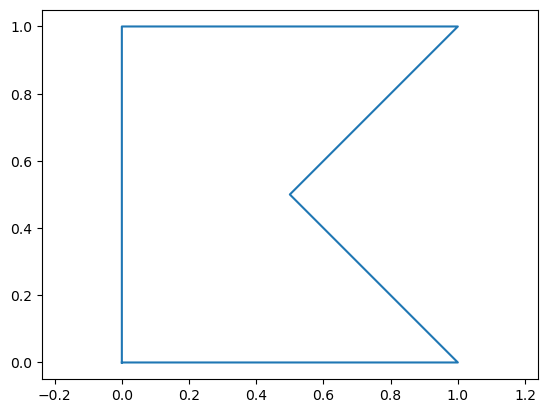

In [2]:
pv = [[0,0], [1,0], [0.5,.5], [1,1], [0,1], [0,0]]
plot(first.(pv), last.(pv))
axis("equal");

In [3]:
length(pv)

6

In [4]:
delaunay(pv)

4-element Vector{Vector{Int64}}:
 [1, 2, 3]
 [2, 4, 3]
 [1, 3, 5]
 [5, 3, 4]

### Problem 1 - Point in polygon

Write a function `inpolygon(p, pv)` which determines if a point `p` is inside the closed polygon `pv`. For example, in the test polygon above, the point $(0.6,0.3)$ is inside but $(0.8,0.3)$ is outside. For the algorithm, use the "Crossing number method" as described here: <https://observablehq.com/@tmcw/understanding-point-in-polygon>.

In [5]:
function inpolygon(p, pv)
    """
    Determines if a point p is inside the closed polygon pv (an array of [x,y] coordinates)
    Uses the Crossing Number Method
    """
    x = p[1]
    y = p[2]
    
    inside = false
    
    l = length(pv)
    
    for i = 1:l
        if i == 1
            j = l
        else
            j = i-1
        end
        
        xi = pv[i][1]
        yi = pv[i][2]
        
        xj = pv[j][1]
        yj = pv[j][2]
        
        intersect = ((yi > y) != (yj > y)) && ( x < (xj - xi)*(y - yi)/(yj - yi) + xi)
        
        if intersect
            inside = !inside
        end
    end
    
    return inside
    
    
end

inpolygon (generic function with 1 method)

In [6]:
#testing 
p1 = [0.8,0.3]
println(p1, inpolygon(p1, pv))

p2 = [0.6, 0.3]
println(p2, inpolygon(p2, pv))


[0.8, 0.3]false
[0.6, 0.3]true


### Problem 2 - Triangle properties

Next we need functions for computing some basic quantities from triangles. Here, a triangle `tri` is represented as an array of 3 points, e.g.

In [7]:
tri = [[1,0.5], [2,1], [0,3]]

3-element Vector{Vector{Float64}}:
 [1.0, 0.5]
 [2.0, 1.0]
 [0.0, 3.0]

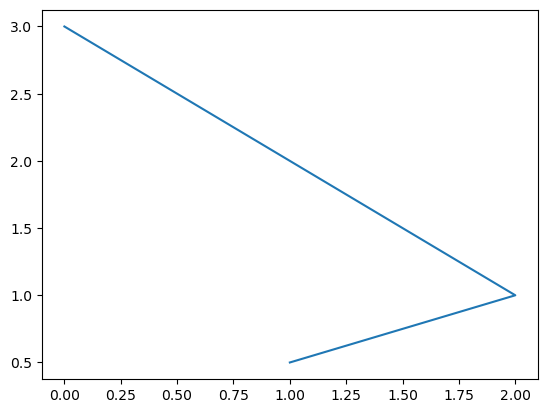

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f96c556e370>

In [8]:
plot(first.(tri), last.(tri))

### Problem 2(a) - Triangle area

Write a function `tri_area(tri)` which returns the area of `tri`.

In [9]:
function tri_area(tri)
    """
    Computes and returns the area of the triangle tri
    """
    Ax = tri[1][1]
    Ay = tri[1][2]
    
    Bx = tri[2][1]
    By = tri[2][2]
    
    Cx = tri[3][1]
    Cy = tri[3][2]

    return 0.5*(Ax*By - Ax*Cy + Bx*Cy - Bx*Ay + Cx*Ay - Cx*By)
end

tri_area (generic function with 1 method)

In [10]:
#testing
tri_area(tri)

1.5

### Problem 2(b) - Triangle centroid

Write a function `tri_centroid(tri)` which returns the centroid of `tri` (<https://en.wikipedia.org/wiki/Centroid#Of_a_triangle>).

In [11]:
function tri_centroid(tri)
    """
    The centroid of a triangle is the point of intersection of its medians
    """
    centroid_x = (tri[1][1] + tri[2][1] + tri[3][1])*(1/3)
    centroid_y = (tri[1][2] + tri[2][2] + tri[3][2])*(1/3)
    
    return [centroid_x, centroid_y]
end

tri_centroid (generic function with 1 method)

In [12]:
#testing
tri_centroid(tri)

2-element Vector{Float64}:
 1.0
 1.5

### Problem 2(c) - Triangle circumcenter

Write a function `tri_circumcenter(tri)` which returns the circumcenter of `tri` (<https://en.wikipedia.org/wiki/Circumscribed_circle#Cartesian_coordinates_2>).

In [13]:
function tri_circumcenter(tri)
    """
    Computes and returns the circumcenter of tri
    """
    A_x = tri[1][1]
    A_y = tri[1][2]
    B_x = tri[2][1]
    B_y = tri[2][2]
    C_x = tri[3][1]
    C_y = tri[3][2]
    
    D = 2*(A_x*(B_y - C_y) + B_x*(C_y - A_y) + C_x*(A_y - B_y))
    
    U_x = (1/D)*((A_x^2 + A_y^2)*(B_y - C_y) + (B_x^2 + B_y^2)*(C_y - A_y) + (C_x^2 + C_y^2)*(A_y - B_y))
    U_y = (1/D)*((A_x^2 + A_y^2)*(C_x - B_x) + (B_x^2 + B_y^2)*(A_x - C_x) + (C_x^2 + C_y^2)*(B_x - A_x))
    
    return [U_x, U_y]
    
    
end

tri_circumcenter (generic function with 1 method)

### Problem 3 - Mesh generator

Write a function with the syntax `p,t = pmesh(pv, hmax)` which generates a mesh `p,t` of the polygon `pv`, with triangle side lengths approximately `hmax`. Follow the algorithm as described below.

(a) The input `pv` is an array of points which defines the polygon. Note that the last point is equal to the first (a closed polygon).

(b) First, create node points `p` along each polygon segment, separated by a distance approximately equal to `hmax`. Make sure not to duplicate any nodes.

(c) Triangulate the domain using the `delaunay` function.

(d) Remove the triangles outside the polygon, by computing all the triangle centroids (using `tri_centroid`) and determining if they are inside (using `inpolygon`).

(e) Find the triangle with largest area $A$ (using `tri_area`). If $A>h_\mathrm{max}^2/2$, add the circumcenter of the triangle to the list of node points `p`.

(f) Repeat steps (c)-(d), that is, re-triangulate and remove outside triangles.

(g) Repeat steps (e)-(f) until no triangle area $A>h_\mathrm{max}^2/2$.

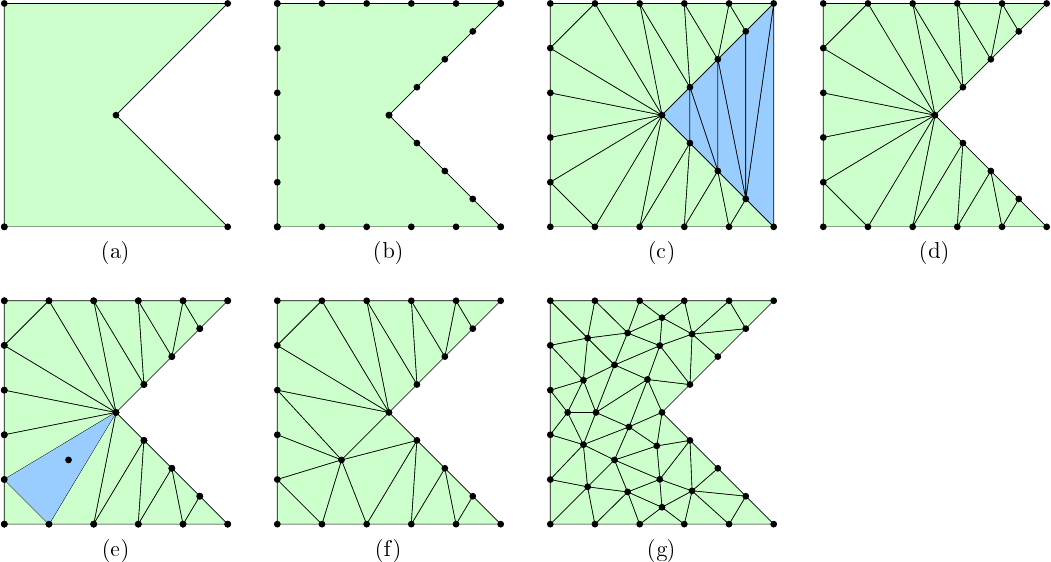

In [35]:
function make_nodes(x_start, y_start, x_stop, y_stop, hmax)
    first = [x_start, y_start]
    nodes = [first]
    
    xdiff = x_stop - x_start
    ydiff = y_stop - y_start

    l = sqrt(xdiff^2 + ydiff^2)
    N = ceil(l / hmax)
    N = convert(Int, N)
    s = range(0, 1, length=N+1)
 
    for i = 1:N+1
        xnew = x_start + s[i]*xdiff
        ynew = y_start + s[i]*ydiff
        next = [xnew, ynew]
        push!(nodes, next)
    end
    
    
    return nodes
end

make_nodes (generic function with 1 method)

$$hmax = \frac{\Delta y}{\Delta x}$$ so $$\Delta x = \frac{\Delta y}{hmax}$$

In [37]:
function triangulate(p, hmax)
    t = delaunay(p)

    #remove triangles outside the domain
    t_inside = []
    for tt in t
        A = p[tt[1]]
        B = p[tt[2]]
        C = p[tt[3]]
        coords = [A, B, C]
        tt_center = tri_centroid(coords)
        if inpolygon(tt_center, pv)
            push!(t_inside, tt)
        end
    end

    #find the largest area
    first = [p[t_inside[1][1]], p[t_inside[1][2]], p[t_inside[1][3]]]
    max_area = 0
    max_cc = tri_centroid(first)
    for tt in t_inside
        A = p[tt[1]]
        B = p[tt[2]]
        C = p[tt[3]]
        coords = [A, B, C]
        
        if tri_area(coords) > max_area
            max_area = tri_area(coords)
            max_cc = tri_centroid(coords)
        end
    end
    return t_inside, max_area, max_cc
end

triangulate (generic function with 1 method)

In [42]:
function pmesh(pv, hmax)
  
    #create node points p about hmax spaced apart 
    p = []
    
    l = length(pv)
    for i = 1:l-1
        j = i+1
        xi, yi = pv[i][1], pv[i][2]
        xj, yj = pv[j][1], pv[j][2]
        
        node_points = make_nodes(xi, yi, xj, yj, hmax)
            
        for point in node_points
            push!(p, point)
        end
    end  
    #p = unique(p)
    

    ti = []
    while true
        ti, max_area, max_cc = triangulate(p, hmax)
        tolerance = ((hmax^2)/2)
        if max_area < tolerance
            break
        end
        push!(p, max_cc)
    end
    
    return p, ti
end

pmesh (generic function with 1 method)

### Test cases

Run the cases below to test your mesh generator.

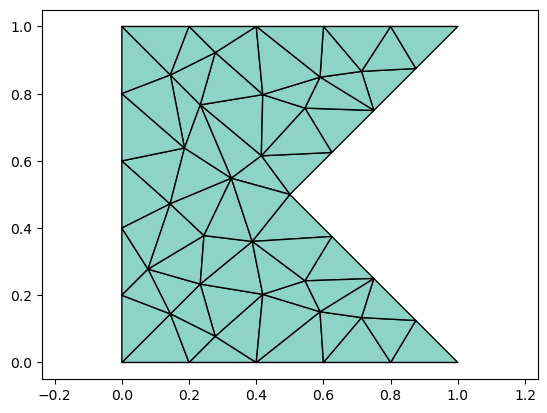

In [43]:
# The polygon in the examples
pv = [[0,0], [1,0], [0.5,.5], [1,1], [0,1], [0,0]]
p,t = pmesh(pv, 0.2)
tplot(p,t)

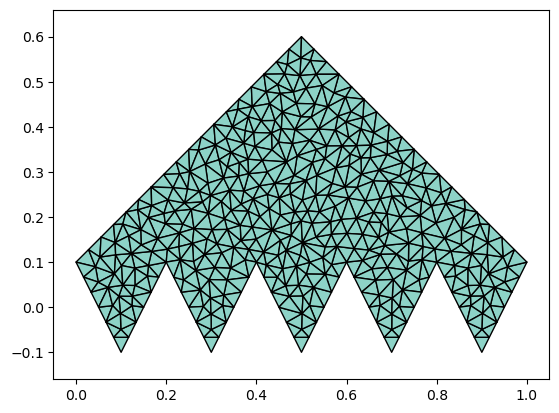

In [34]:
# A more complex shape
pv = [[i/10,0.1*(-1)^i] for i = 0:10]
append!(pv, [[.5,.6], [0,.1]])
p,t = pmesh(pv, 0.04)
tplot(p,t)